# 0 Import modules

In [28]:
# importing necessary libraries
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn
from torch import optim

# 1 Import dataset

In [29]:
#transforming images to tensors
#using the transforms module to convert the images in the dataset into Tensors
trans = transforms.ToTensor()

#PyTorch already has the library MNIST prepared, we set whether we want the training set or the testing set
trainset = datasets.MNIST(r'C:\Users\youzh\Documents\My documents (backed up)\UCSB\Math 108C\Project', \
                          train=True, transform = trans)

testset = datasets.MNIST(r'C:\Users\youzh\Documents\My documents (backed up)\UCSB\Math 108C\Project', \
                         train=False, transform = trans)

#we divide the dataset into smaller batches of size 32 for stochastic gradient desent
training = torch.utils.data.DataLoader(trainset, batch_size=120, shuffle=True)
testing = torch.utils.data.DataLoader(testset, batch_size=120, shuffle=True)

### 1.1 View Dataset

shape of images:  torch.Size([120, 1, 28, 28])
shape of labels:  torch.Size([120])


Text(0.5, 1.0, 'Example of image with label: 1')

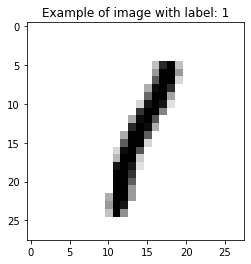

In [30]:
example = iter(training) #using iter so we can see what the number looks like
images, labels = example.next()

print("shape of images: ", images.shape)
print("shape of labels: ", labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r'); #plots the matrices as images
plt.title(f"Example of image with label: {labels[0]}")

#32 numbers in one batch so has dimension 32
#torch.set_printoptions(profile="full")
#print(images)

Text(0.5, 0.98, 'collection of 30 images')

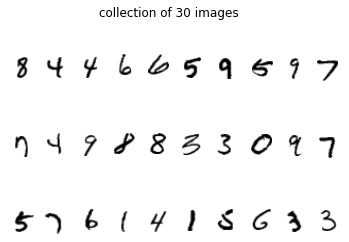

In [31]:
figure = plt.figure()
num = 30
for i in range(1, num + 1):
    plt.subplot(3, 10, i)
    plt.axis('off')
    plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')
plt.suptitle("collection of 30 images")

# 2 Define Neural Network

In [32]:
# We are using a simple 3 Layer network
input_size = 784 #input layer
hidden_size = 30 #hidden layer
output_size = 10 #output layer

#using the neural network (nn) module from pytorch, we can create our network in very few lines:
model = nn.Sequential(nn.Linear(input_size, hidden_size),
                      nn.Sigmoid(),
                      nn.Linear(hidden_size, output_size)).double()

criterion = nn.MSELoss(reduction='mean') #using Mean squared Error as our loss function
#criterion = nn.CrossEntropyLoss()

### 2.1 Choose device for computation

In [33]:
#using GPU/CPU for computations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#uses gpu if available

print("using device:" ,device)
model.to(device) #moving our model to GPU

using device: cuda


Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=30, out_features=10, bias=True)
)

# Train Neural Network

In [34]:
# some helper functions that convert the labels from a number i between 0-9 
# to a tensor of size 10 with 1 in the i-th position to be used for the loss function
def labelToTensor(label):
    vec = np.zeros(10)
    vec[label] = 1
    return torch.from_numpy(vec)

def LabelsToTensors(vec):
    list1 = []
    for i in range(len(vec)):
        list1.append(labelToTensor(vec[i]))
    tensor = torch.stack(list1)
    return tensor

#LabelsToTensors([1,2,3,4,5,6,7,8,9,0])

In [35]:
# The main training step

#using stochastic gradient descent to optimize our neural network
optimizer = optim.SGD(model.parameters(), lr=1)

time0 = time()
epochs = 30

for e in range(epochs):
    running_loss = 0
    for images, labels in testing:
        
        # Flatten MNIST images into a size 784 vector
        images = images.view(images.shape[0], -1)
        
        # Training pass
        optimizer.zero_grad()
        
        output = model((images.double()).cuda())

        labelsAsTensors = LabelsToTensors(labels)
        
        loss = criterion(output, labelsAsTensors.cuda())
        #loss = criterion(output)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Epoch {e+1} - Average loss of Epoch: {running_loss/len(testing):.4f}")
runtime = time()-time0
print(f"\nTraining Time:  {runtime:.1f} seconds")

Epoch 1 - Average loss of Epoch: 0.0745
Epoch 2 - Average loss of Epoch: 0.0512
Epoch 3 - Average loss of Epoch: 0.0450
Epoch 4 - Average loss of Epoch: 0.0418
Epoch 5 - Average loss of Epoch: 0.0400
Epoch 6 - Average loss of Epoch: 0.0380
Epoch 7 - Average loss of Epoch: 0.0366
Epoch 8 - Average loss of Epoch: 0.0352
Epoch 9 - Average loss of Epoch: 0.0339
Epoch 10 - Average loss of Epoch: 0.0326
Epoch 11 - Average loss of Epoch: 0.0313
Epoch 12 - Average loss of Epoch: 0.0303
Epoch 13 - Average loss of Epoch: 0.0292
Epoch 14 - Average loss of Epoch: 0.0282
Epoch 15 - Average loss of Epoch: 0.0273
Epoch 16 - Average loss of Epoch: 0.0263
Epoch 17 - Average loss of Epoch: 0.0255
Epoch 18 - Average loss of Epoch: 0.0249
Epoch 19 - Average loss of Epoch: 0.0243
Epoch 20 - Average loss of Epoch: 0.0237
Epoch 21 - Average loss of Epoch: 0.0231
Epoch 22 - Average loss of Epoch: 0.0226
Epoch 23 - Average loss of Epoch: 0.0222
Epoch 24 - Average loss of Epoch: 0.0216
Epoch 25 - Average loss o

# Evaluate Neural Network

Number Of Images Tested = 10000

Model Accuracy = 0.9238

Average Testing Time:  0.0004 seconds


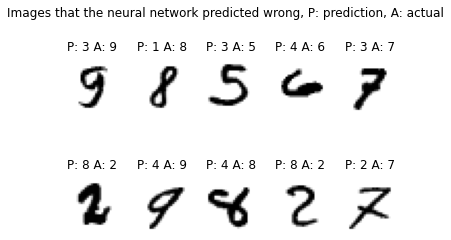

In [36]:
correct_count, all_count = 0, 0
time0 = time()
counter1 = 0
counter2 = 0
figure = plt.figure()
for images,labels in testing:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        
        # Turn off gradients to speed up this part
        with torch.no_grad():
            #probs = model(img.double()) for CPU
            probs = model((img.double()).cuda())
        #print(probs)
            
        probs = list(probs.cpu().numpy()[0])
        #print(probs)
        #break
        pred_label = probs.index(max(probs))
        
        true_label = labels.numpy()[i]
        
        if(true_label == pred_label):
            correct_count += 1
        else:
            counter1 +=1
            if counter1 <=10:
                plt.subplot(2, 5, counter1)
                plt.axis('off')
                plt.title(f"P: {pred_label} A: {true_label}")
                plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')
        all_count += 1

plt.suptitle("Images that the neural network predicted wrong, P: prediction, A: actual")
print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))
runtime = time()-time0
print(f"\nAverage Testing Time:  {runtime/all_count:.4f} seconds")